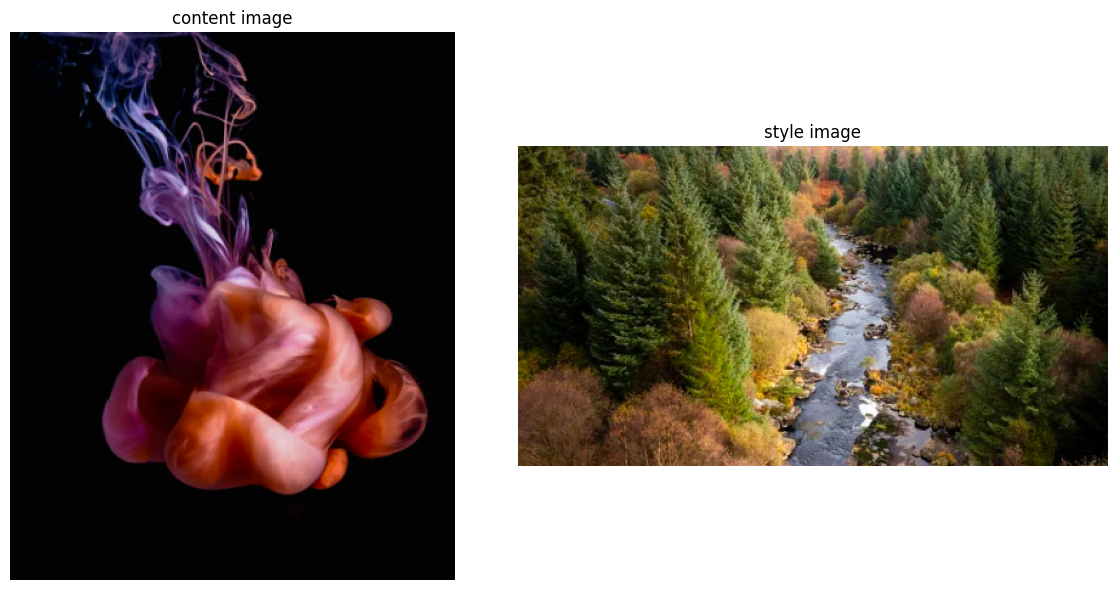

In [21]:
from PIL import Image
import matplotlib.pyplot as plt


content_image = Image.open('content.png')
style_image = Image.open('style.png')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(content_image)
axes[0].axis('off') 
axes[0].set_title('content image')

axes[1].imshow(style_image)
axes[1].axis('off')  
axes[1].set_title('style image')

plt.tight_layout()  
plt.show()


In [22]:
# importing libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [4]:
content_path = 'content.png'  
style_path = 'style.png'

In [31]:
def load_and_process_image(image_path, target_size=(400, 400)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [33]:
target_size = (400, 400)
content_image = load_and_process_image(content_path, target_size)
style_image = load_and_process_image(style_path, target_size)

In [34]:
# Load VGG19 model (pre-trained on ImageNet)
vgg = vgg19.VGG19(weights='imagenet', include_top=False)
vgg.trainable = False

# Extract features from intermediate layers
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layer = 'block4_conv2'
layers = style_layers + [content_layer]
model_outputs = [vgg.get_layer(layer).output for layer in layers]
model = Model(inputs=vgg.input, outputs=model_outputs)

In [35]:
# Compute content loss
def compute_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# Compute gram matrix for style loss
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    matrix = tf.reshape(tensor, [-1, channels])
    gram = tf.matmul(tf.transpose(matrix), matrix)
    return gram

# Compute style loss
def compute_style_loss(base_style, gram_target):
    gram_base = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_base - gram_target))

# Get feature representations
def get_feature_representations(model, content_path, style_path):
    content_image = load_and_process_image(content_path, target_size)
    style_image = load_and_process_image(style_path, target_size)
    content_features = model(content_image)
    style_features = model(style_image)
    return content_features, style_features

# Compute losses and gradients
def compute_loss_and_grads(model, content_features, style_features, generated_image):
    with tf.GradientTape() as tape:
        generated_features = model(generated_image)
        content_loss = compute_content_loss(generated_features[-1], content_features[-1])

        # Calculate Gram matrices for style features *before* the loop
        style_gram_matrices = [gram_matrix(feature) for feature in style_features[:-1]]  # Exclude content feature

        style_loss = tf.add_n([compute_style_loss(generated_features[i], style_gram_matrices[i]) for i in range(len(style_layers))])
        total_loss = content_loss * 1.0 + style_loss * 1e-4
    grads = tape.gradient(total_loss, generated_image)
    return total_loss, grads

In [36]:
# Run optimization
content_features, style_features = get_feature_representations(model, content_path, style_path)
generated_image = tf.Variable(content_image, dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam(learning_rate=5.0)

In [37]:
# Deprocess image (convert from VGG19 format to normal image)
def deprocess_image(img):
    img = img.reshape((400, 400, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]  # Convert BGR to RGB
    img = np.clip(img, 0, 255).astype('uint8')
    return img

2025-04-28 09:47:56.639768: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2025-04-28 09:47:56.737678: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2025-04-28 09:47:57.133549: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 368640000 exceeds 10% of free system memory.
2025-04-28 09:47:57.296884: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 368640000 exceeds 10% of free system memory.


Iteration 0: Loss = 116520785018880.0


2025-04-28 09:47:59.683742: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.


Iteration 1: Loss = 82367263801344.0
Iteration 2: Loss = 52255642353664.0
Iteration 3: Loss = 37853903978496.0
Iteration 4: Loss = 30197556445184.0
Iteration 5: Loss = 27293508435968.0
Iteration 6: Loss = 25013526724608.0
Iteration 7: Loss = 22297821839360.0
Iteration 8: Loss = 19911585824768.0
Iteration 9: Loss = 17743550087168.0
Iteration 10: Loss = 15655573127168.0
Iteration 11: Loss = 13777766449152.0
Iteration 12: Loss = 12258581151744.0
Iteration 13: Loss = 11136513605632.0
Iteration 14: Loss = 10262965911552.0
Iteration 15: Loss = 9509549375488.0
Iteration 16: Loss = 8922036436992.0
Iteration 17: Loss = 8440754208768.0
Iteration 18: Loss = 8033668694016.0
Iteration 19: Loss = 7679545180160.0
Iteration 20: Loss = 7347780452352.0
Iteration 21: Loss = 7050445193216.0
Iteration 22: Loss = 6759269793792.0
Iteration 23: Loss = 6473375023104.0
Iteration 24: Loss = 6204380151808.0
Iteration 25: Loss = 5945766707200.0
Iteration 26: Loss = 5696512851968.0
Iteration 27: Loss = 545609482240

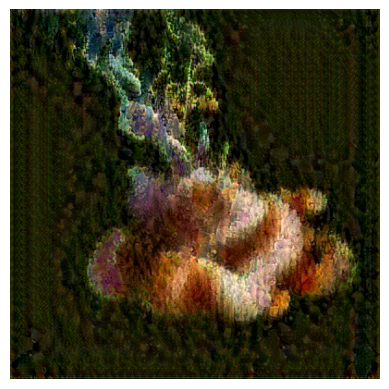

In [38]:
# Training loop
iterations = 42
for i in range(iterations):
    loss, grads = compute_loss_and_grads(model, content_features, style_features, generated_image)
    optimizer.apply_gradients([(grads, generated_image)])
    print(f"Iteration {i}: Loss = {loss.numpy()}")
    if i == iterations - 1:
        output_image = deprocess_image(generated_image.numpy())
        plt.imshow(output_image)
        plt.axis('off')
        plt.show()

In [ ]:
# ### Problem Statement Explanation

# The problem is to create art by applying **Neural Style Transfer (NST)** to a given content image using deep 
# learning techniques. The goal is to combine the content of one image (the **content image**) with the style of
# another image (the **style image**) to generate a new image that has the content of the first image and the 
# artistic style of the second.

# Here’s the basic idea behind **Neural Style Transfer (NST)**:
# 1. **Content Image**: This is the image whose content (shapes, objects, etc.) you want to retain.
# 2. **Style Image**: This is the image whose artistic style (textures, colors, patterns) you want to transfer 
#     to the content image.
# 3. **Generated Image**: This is the output image that will have the content of the content image and the style 
#     of the style image.

# The process involves:
# - Using a **Convolutional Neural Network (CNN)** to extract features from the content and style images.
# - Defining **loss functions** to measure the difference between the features of the content image, style image,
# and the generated image.
# - Using **gradient descent** to minimize the difference between these features and thus generate a new image.

# ### Code Explanation (Line by Line)

# ```python
# # importing libraries
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt
# import PIL.Image
# from tensorflow.keras.applications import vgg19
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# ```
# - **`tensorflow`**: Used for creating and training deep learning models.
# - **`numpy`**: Library for numerical operations, like array manipulation.
# - **`matplotlib.pyplot`**: For displaying images and visualizations.
# - **`PIL.Image`**: For image processing.
# - **`vgg19`**: A pre-trained VGG19 model from Keras, used for feature extraction.
# - **`Model`**: This helps create a custom model by selecting layers of the pre-trained VGG19 model.
# - **`load_img, img_to_array`**: Functions to load images and convert them to arrays for processing.

# ```python
# content_path = 'content.png'  
# style_path = 'style.png'
# ```
# - **`content_path`** and **`style_path`** store the file paths to the content and style images you want to use.

# ```python
# def load_and_process_image(image_path, target_size=(400, 400)):
#     img = load_img(image_path, target_size=target_size)
#     img = img_to_array(img)
#     img = np.expand_dims(img, axis=0)
#     img = vgg19.preprocess_input(img)
#     return img
# ```
# - This function **loads and preprocesses** an image.
#   - **`load_img(image_path, target_size)`** loads the image from the specified path and resizes it to the 
#     specified dimensions (`400x400` by default).
#   - **`img_to_array(img)`** converts the image into a numpy array.
#   - **`np.expand_dims(img, axis=0)`** adds a batch dimension to the image (as the model expects a batch of 
#                                                                            images, even if there's only one 
#                                                                            image).
#   - **`vgg19.preprocess_input(img)`** applies preprocessing steps to the image (mean subtraction and 
#                                                                                 normalization) 
# required by the VGG19 model.

# ```python
# target_size = (400, 400)
# content_image = load_and_process_image(content_path, target_size)
# style_image = load_and_process_image(style_path, target_size)
# ```
# - These lines load and preprocess both the content and style images.

# ```python
# # Load VGG19 model (pre-trained on ImageNet)
# vgg = vgg19.VGG19(weights='imagenet', include_top=False)
# vgg.trainable = False
# ```
# - This loads the pre-trained **VGG19** model without the fully connected layers (`include_top=False`) 
# because we are interested in the convolutional layers for feature extraction.
# - **`weights='imagenet'`** means the model is pre-trained on the ImageNet dataset.
# - **`vgg.trainable = False`** freezes the model's weights so they aren’t updated during training 
# (we only use it for feature extraction).

# ```python
# # Extract features from intermediate layers
# style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
# content_layer = 'block4_conv2'
# layers = style_layers + [content_layer]
# model_outputs = [vgg.get_layer(layer).output for layer in layers]
# model = Model(inputs=vgg.input, outputs=model_outputs)
# ```
# - **`style_layers`** defines the layers where we will extract the style features. These layers contain 
# information about texture and patterns.
# - **`content_layer`** defines the layer where we will extract the content features. This layer contains 
# information about the high-level structure of the image.
# - **`model_outputs`** collects the output of the selected layers (both content and style layers).
# - **`Model(inputs=vgg.input, outputs=model_outputs)`** creates a new model that outputs the selected layers.

# ```python
# # Compute content loss
# def compute_content_loss(base_content, target):
#     return tf.reduce_mean(tf.square(base_content - target))
# ```
# - **`compute_content_loss`** computes the difference between the content of the generated image 
# (`base_content`) and the content of the target image (`target`). It uses **Mean Squared Error (MSE)** 
# as the content loss function.

# ```python
# # Compute gram matrix for style loss
# def gram_matrix(tensor):
#     channels = int(tensor.shape[-1])
#     matrix = tf.reshape(tensor, [-1, channels])
#     gram = tf.matmul(tf.transpose(matrix), matrix)
#     return gram
# ```
# - The **Gram matrix** is used to represent the correlations between the feature maps of a convolutional layer.
# - It helps measure how much style (texture, patterns) is present in the image.
# - **`gram_matrix`** reshapes the feature map and computes the matrix product to get the correlations.

# ```python
# # Compute style loss
# def compute_style_loss(base_style, gram_target):
#     gram_base = gram_matrix(base_style)
#     return tf.reduce_mean(tf.square(gram_base - gram_target))
# ```
# - **`compute_style_loss`** calculates the difference between the Gram matrix of the generated image 
# (`gram_base`) and the Gram matrix of the target style (`gram_target`).

# ```python
# # Get feature representations
# def get_feature_representations(model, content_path, style_path):
#     content_image = load_and_process_image(content_path, target_size)
#     style_image = load_and_process_image(style_path, target_size)
#     content_features = model(content_image)
#     style_features = model(style_image)
#     return content_features, style_features
# ```
# - This function computes the feature representations of both the content and style images using the model.

# ```python
# # Compute losses and gradients
# def compute_loss_and_grads(model, content_features, style_features, generated_image):
#     with tf.GradientTape() as tape:
#         generated_features = model(generated_image)
#         content_loss = compute_content_loss(generated_features[-1], content_features[-1])

#         # Calculate Gram matrices for style features *before* the loop
#         style_gram_matrices = [gram_matrix(feature) for feature in style_features[:-1]]  # Exclude content 
#         feature

#         style_loss = tf.add_n([compute_style_loss(generated_features[i], style_gram_matrices[i]) 
#                                for i in range(len(style_layers))])
#         total_loss = content_loss * 1.0 + style_loss * 1e-4
#     grads = tape.gradient(total_loss, generated_image)
#     return total_loss, grads
# ```
# - This function computes the **total loss** (content loss + style loss) and the **gradients** with 
# respect to the generated image.
# - The gradient descent algorithm will minimize the total loss to update the generated image.

# ```python
# # Run optimization
# content_features, style_features = get_feature_representations(model, content_path, style_path)
# generated_image = tf.Variable(content_image, dtype=tf.float32)
# optimizer = tf.keras.optimizers.Adam(learning_rate=5.0)
# ```
# - **`get_feature_representations`** is called to get the feature representations of the content and style
# images.
# - The **generated image** is initialized as a variable with the content image.
# - **`optimizer = tf.keras.optimizers.Adam(learning_rate=5.0)`** sets up the Adam optimizer with a specified 
# learning rate for gradient descent.

# ```python
# # Deprocess image (convert from VGG19 format to normal image)
# def deprocess_image(img):
#     img = img.reshape((400, 400, 3))
#     img[:, :, 0] += 103.939
#     img[:, :, 1] += 116.779
#     img[:, :, 2] += 123.68
#     img = img[:, :, ::-1]  # Convert BGR to RGB
#     img = np.clip(img, 0, 255).astype('uint8')
#     return img
# ```
# - **`deprocess_image`** converts the generated image from the VGG19 format (which uses BGR and mean subtraction) 
# back to the normal RGB format.

# ```python
# # Training loop
# iterations = 42
# for i in range(iterations):
#     loss, grads = compute_loss_and_grads(model, content_features, style_features, generated_image)
#     optimizer.apply_gradients([(grads, generated_image)])
#     print(f"Iteration {i}: Loss = {loss.numpy()}")
#     if i == iterations - 1:
#         output_image = deprocess_image(generated_image.numpy())
#         plt.imshow(output_image)
#         plt.axis('off')
#         plt.show()
# ```
# - This is the **training loop** where the optimization happens.
#   - In each iteration, the model computes the loss and gradients, and the optimizer updates the generated image.
#   - **`print(f"Iteration {i}: Loss = {loss.numpy()}")`** prints the current loss to monitor the training progress.
#   - After all iterations, the generated image is deprocessed and displayed using `matplotlib`.

# ### Conclusion
# This code successfully implements Neural Style Transfer by combining the content of one image with the artistic
# style of another using a pre-trained deep learning model (VGG19). The result is an image that retains 
# the content of the first image and adopts the artistic style of the second image.